In [1]:
# Installing all the packages.
!pip install pandas numpy tensorflow scikit-learn matplotlib

In [2]:
# Importing all the libraries.
# Data Manipulation
import pandas as pd
import numpy as np

# ML Neural Network
import tensorflow as tf

# Content Based Filtering Implementation
from sklearn.feature_extraction.text import TfidfVectorizer

# Training
from sklearn.model_selection import train_test_split

# Evaluation
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, root_mean_squared_error, accuracy_score
import matplotlib.pyplot as plt
import time

In [3]:
# Run on Google Colab: If blank then CPU is being used, swap to T4 GPU by clicking the top right down arrow to swap run time type.
# Make sure output is "Found GPU at: /device:GPU:0".
device = tf.test.gpu_device_name()
print('Found GPU at: {}'.format(device))

Found GPU at: /device:GPU:0


**AI Content Based Filtering**

In [4]:
class CBFDataPreprocessing:
    def __init__(self):
        self.movies_df = None
        self.ratings_df = None
        self.tags_df = None

    def load_csv(self):
        # Loading all the MovieLens dataset files.
        self.movies_df = pd.read_csv('movies.csv') # MovieId, Title, Genres
        self.ratings_df = pd.read_csv('ratings.csv') # UserId, MovieId, Rating, Timestamp
        self.tags_df = pd.read_csv('tags.csv') # UserId, MovieId, Tag, Timestamp

    def preprocess_data(self):
        # Data Pre-processing
        # Drop 'Timestamp' column from dataset.
        self.ratings_df = self.ratings_df.drop(columns=['timestamp'])
        self.tags_df = self.tags_df.drop(columns=['timestamp'])

        # Replace no genre films with empty string (' ').
        self.movies_df['genres'] = self.movies_df['genres'].replace('(no genres listed)', '')

        # Fill empty genre/tags with empty string (' ').
        self.movies_df['genres'] = self.movies_df['genres'].fillna('')
        self.tags_df['tag'] = self.tags_df['tag'].fillna('')

        # Remove '|' between each genre in the movies dataframe.
        self.movies_df['genres'] = self.movies_df['genres'].str.replace('|', ' ')

        # Combine all tags into one string for every movie.
        self.tags = self.tags_df.groupby('movieId')['tag'].agg(' '.join).reset_index()
        self.tags.columns = ['movieId', 'tags_df']

        # Merge the columns from the tags dataframe into the movies dataframe.
        self.movies_df = pd.merge(self.movies_df, self.tags, on='movieId', how='left')
        self.movies_df['tags_df'] = self.movies_df['tags_df'].fillna('')

        # Merge the movie dataframe with user ratings
        self.movie_ratings_df = pd.merge(self.ratings_df, self.movies_df, on='movieId')

        # Create a column called label and fill with true (1) if rating is >= 4 else false (0).
        self.movie_ratings_df['liked'] = (self.movie_ratings_df['rating'] >= 4.0).astype(int)

In [5]:
class MovieFeatures:
    def tfidf_matrix(self):
        # Using term frequency to convert documents into numerical vectors for ML.
        # Creates a vector and ignores common Egnlish words like 'and'.
        # min_df ignore words that appear < 5 movies, and max_df ignores words that appear more than 80% in the movies dataframe.
        self.tfidf_vector = TfidfVectorizer(stop_words='english', min_df=2, max_df=0.8)

        # Creates a matrix from the vectors where rows are movies and columns are genre words,
        # filled with TFIDF values (how important each word is in the document).
        self.tfidf_matrix = self.tfidf_vector.fit_transform(self.movies_df['genres'] + ' ' + self.movies_df['tags_df'])

    def id_mapping(self):
        # Mapping movieId to the TFIDF index.
        self.lookup = pd.Series(data=np.arange(len(self.movies_df)), index=self.movies_df['movieId']).to_dict()
        self.movie_ratings_df['tfidf_index'] = self.movie_ratings_df['movieId'].map(self.lookup)

        # Filter out non existing movie id.
        self.movie_ratings_df = self.movie_ratings_df.dropna(subset=['tfidf_index'])

        # Converts float values into integer values so it can be used to index later.
        self.movie_ratings_df['tfidf_index'] = self.movie_ratings_df['tfidf_index'].astype(int)

    def training(self):
        # Retrives the index of the movie rated by the user.
        self.tfidf_indices = self.movie_ratings_df['tfidf_index'].to_numpy()

        # Gets the movie (by the index) with a rating.
        self.lookup_movie_rating = self.tfidf_matrix[self.tfidf_indices]

        # Convert to an array and gets the user's rating (whether they liked the movie or not).
        self.X = self.lookup_movie_rating.toarray()
        self.y = self.movie_ratings_df['liked'].to_numpy()
        return self.X, self.y

In [6]:
class DataSplit:
    # 20% of data is used for testing.
    def __init__(self, test_data=0.2, seed=42):
        self.test_data = test_data
        self.seed = seed

    def split(self):
        # X = features, y = labels, splitting the dataset into testing and training.
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=self.test_data, random_state=self.seed)
        return self.X_train, self.X_test, self.y_train, self.y_test

In [7]:
class CBFClassifier:
    # Tensorflow classifier
    def __init__(self):
        # Using these Neural Network layers.
        self.activation1 = 'relu' # Simple and fast to compute.
        self.activation2 = 'sigmoid' # Provides values between 0 and 1.
        self.optimizer = 'adam' # Adapts the learning rate.
        self.loss = 'binary_crossentropy' # Ideal for probabilities and binary labels (whether the user liked the movie or not).
        self.metrics = ['accuracy']

    def model(self):
        self.model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(self.X.shape[1],)),
            tf.keras.layers.Dense(128, activation=self.activation1),
            tf.keras.layers.Dropout(0.3), # Less chances of overfitting (memorising the training data).
            tf.keras.layers.Dense(64, activation=self.activation1),
            tf.keras.layers.Dense(1, activation=self.activation2)
        ])
        self.model.compile(optimizer=self.optimizer, loss=self.loss, metrics=self.metrics)

In [8]:
# Full model combining the other classes into one.
class CBFModel:
    def __init__(self):
        # Calling the other classes.
        self.preprocessing = CBFDataPreprocessing()
        self.features = MovieFeatures()
        self.datasplit = DataSplit()
        self.classifier = CBFClassifier()

    def forward(self):
        # Data pre-processing.
        self.preprocessing.load_csv()
        self.preprocessing.preprocess_data()

        # Movie feature extraction.
        self.features.movies_df = self.preprocessing.movies_df
        self.features.movie_ratings_df = self.preprocessing.movie_ratings_df
        self.features.tfidf_matrix()
        self.features.id_mapping()
        X, y = self.features.training()

        # Split data into training and testing.
        self.datasplit.X = X
        self.datasplit.y = y
        X_train, X_test, y_train, y_test = self.datasplit.split()

        # Building and training the model.
        self.classifier.X = X_train
        self.classifier.layers = tf.keras.layers.Layer
        self.classifier.model()

        # Calculating how long training takes for X amount of epochs for evaluation.
        start = time.time()
        # Records the progression of the training/test loss and accuracy across X amount of epochs for evaluation.
        training_record = self.classifier.model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.1)
        end = time.time()
        print("Training took", end - start, "seconds")

        # Graphs for the evolution of loss.
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(training_record.history['loss'], label='Train Loss', color='orange')
        plt.title('Evolution of Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Graph for evolution of training and validation accuracies.
        plt.subplot(1, 2, 2)
        plt.plot(training_record.history['accuracy'], label='Train Accuracy', color='blue')
        plt.plot(training_record.history['val_accuracy'], label='Test Accuracy', color='green')
        plt.title('Evolution of Training and Validation Accuracies')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.suptitle("AI Content Based Filtering")
        plt.show()

In [9]:
class CBFRecommendations:
    def __init__(self, user, model, movies_df, ratings_df, tfidf_matrix, lookup):
        self.user_id = user
        self.model = model
        self.movies_df = movies_df
        self.ratings_df = ratings_df
        self.tfidf_matrix = tfidf_matrix
        self.lookup = lookup

    def recommendations(self):
        # Filtering out movies that the user has rated.
        rated_movies = self.ratings_df[self.ratings_df['userId'] == self.user_id] # Comparing user ID.
        rated_movie_id = rated_movies['movieId'].values # Retrieving the movie ID.

        # Finding movies not seen by the user, maps movie ID to TFIDF matrix.
        unseen_movies = self.movies_df[~self.movies_df['movieId'].isin(rated_movie_id)].copy()
        unseen_movies['tfidf_index'] = unseen_movies['movieId'].map(self.lookup)
        unseen_movies = unseen_movies.dropna(subset=['tfidf_index'])
        unseen_movies['tfidf_index'] = unseen_movies['tfidf_index'].astype(int)

        # Potential recommendations on new movies
        indices = unseen_movies['tfidf_index'].to_numpy()
        candidates = self.tfidf_matrix[indices].toarray()

        # Recommend top 10 movies for user X based on predicted score.
        score = self.model.predict(candidates).flatten()
        unseen_movies['score'] = score
        recommendations = unseen_movies.sort_values(by='score', ascending=False).head(10)

        # Display top 10 recommendations for user X.
        print("We recommend these 10 movies for User", self.user_id)
        print(recommendations[['movieId', 'title', 'genres']])

**Neural Collaborative Filtering**

In [10]:
class NCFDataPreprocessing:
    def __init__(self):
        self.movies_df = None
        self.ratings_df = None

    def load_csv(self):
        # Loading all the MovieLens dataset files.
        self.movies_df = pd.read_csv('movies.csv') # MovieId, Title, Genres
        self.ratings_df = pd.read_csv('ratings.csv') # UserId, MovieId, Rating, Timestamp

    def preprocess_data(self):
        # Data Pre-processing
        # Drop 'Timestamp' column from dataset.
        self.ratings_df = self.ratings_df.drop(columns=['timestamp'])
        # Remove '|' between each genre in the movies dataframe.
        self.movies_df['genres'] = self.movies_df['genres'].str.replace('|', ' ')

In [11]:
class IDEncoder:
    def __init__(self):
       self.userid_index = {}
       self.movieid_index = {}

    # Encoding user/movie IDs - converting scattered data into sequential integers.
    def encode_ids(self):
        # Remove duplicate user/movie IDs and store into a list.
        self.user_id = self.ratings_df['userId'].unique().tolist()
        self.movie_id = self.ratings_df['movieId'].unique().tolist()

        # Store these into a dictionary | userId 15 = 0 etc.
        for i, x in enumerate(self.user_id):
            self.userid_index[x] = i

        for i, x in enumerate(self.movie_id):
            self.movieid_index[x] = i

        # Create a new column and map the encoder to the original user/movie ID.
        self.ratings_df['user'] = self.ratings_df['userId'].map(self.userid_index)
        self.ratings_df['movie'] = self.ratings_df['movieId'].map(self.movieid_index)

        # Total no. users/movies, used later in the embeddings.
        self.user_count = len(self.userid_index)
        self.movie_count = len(self.movieid_index)

In [12]:
# Same method used for Content Based Filtering.
class DataSplit:
    # 20% of data is used for testing.
    def __init__(self, test_data=0.2, seed=42):
        self.test_data = test_data
        self.seed = seed

    def split(self):
        # X = features, y = labels, splitting the dataset into testing and training.
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=self.test_data, random_state=self.seed)
        return self.X_train, self.X_test, self.y_train, self.y_test

In [13]:
class NCFClassifier:
    # Tensorflow classifier
    def __init__(self):
        # Using these Neural Network layers.
        self.embedding_size = 50
        self.activation1 = 'relu'
        self.activation2 = 'sigmoid'
        self.optimizer = 'adam'
        self.loss = 'binary_crossentropy'
        self.metrics = ['accuracy']

    def inputs(self):
        self.user_input = tf.keras.layers.Input(
            shape = (1,),
            name = 'user_input'
        )
        self.item_input = tf.keras.layers.Input(
            shape = (1,),
            name = 'movie_input'
        )

    # Create User / Item embeddings so it can be trained and understand hidden patterns (user likes movie X, movie is comedy).
    def embeddings(self):
        self.user_embedding_gmf = tf.keras.layers.Embedding(
            input_dim = self.user_count,
            output_dim = self.embedding_size)
        self.user_embedding_gmf = self.user_embedding_gmf(self.user_input)

        self.item_embedding_gmf = tf.keras.layers.Embedding(
            input_dim = self.movie_count,
            output_dim = self.embedding_size)
        self.item_embedding_gmf = self.item_embedding_gmf(self.item_input)

        self.user_embedding_mlp = tf.keras.layers.Embedding(
            input_dim = self.user_count,
            output_dim = self.embedding_size)
        self.user_embedding_mlp = self.user_embedding_mlp(self.user_input)

        self.movie_embedding_mlp = tf.keras.layers.Embedding(
            input_dim = self.movie_count,
            output_dim = self.embedding_size)
        self.movie_embedding_mlp = self.movie_embedding_mlp(self.item_input)

    # Generalised Matrix Factorisation Layer - learning simple relationships.
    def GMF (self):
        self.user_vector_gmf = tf.keras.layers.Flatten()(self.user_embedding_gmf)
        self.movie_vector_gmf = tf.keras.layers.Flatten()(self.item_embedding_gmf)
        self.gmf = tf.keras.layers.Multiply()([self.user_vector_gmf, self.movie_vector_gmf])

    # Multi-Layer Perceptron Layer - learning complex relationships.
    def MLP (self):
        self.user_vector_mlp = tf.keras.layers.Flatten()(self.user_embedding_mlp)
        self.movie_vector_mlp = tf.keras.layers.Flatten()(self.movie_embedding_mlp)

        # Train and learn more complex relations.
        self.mlp = tf.keras.layers.Concatenate()([self.user_vector_mlp, self.movie_vector_mlp])
        self.mlp = tf.keras.layers.Dense(128, activation=self.activation1)(self.mlp)
        self.mlp = tf.keras.layers.Dropout(0.3)(self.mlp)
        self.mlp = tf.keras.layers.Dense(64, activation=self.activation1)(self.mlp)

    # Creating Neural Matrix Factorisation Layer - Combining both simple and complex relations to make predictions.
    def concatenate(self):
        neural_matrix_factorisation = tf.keras.layers.Concatenate()([self.gmf, self.mlp])
        self.output_layer = tf.keras.layers.Dense(1, activation=self.activation2)(neural_matrix_factorisation)

    def model(self):
        self.model = tf.keras.Model(inputs=[self.user_input, self.item_input], outputs=self.output_layer)
        self.model.compile(optimizer=self.optimizer, loss=self.loss, metrics=self.metrics)

In [14]:
class NCFModel:
    def __init__(self):
        # Calling the other classes.
        self.preprocessing = NCFDataPreprocessing()
        self.encoder = IDEncoder()
        self.datasplit = DataSplit()
        self.classifier = NCFClassifier()

    def forward(self):
        # Data pre-processing.
        self.preprocessing.load_csv()
        self.preprocessing.preprocess_data()

        # Encode user and movie IDs.
        self.encoder.ratings_df = self.preprocessing.ratings_df
        self.encoder.encode_ids()

        # After encoding, features should be updated to ensure the training is using the new data.
        self.preprocessing.ratings_df = self.encoder.ratings_df
        self.classifier.user_count = self.encoder.user_count
        self.classifier.movie_count = self.encoder.movie_count

        # X holds the user, movie pair.
        self.datasplit.X = self.preprocessing.ratings_df[['user', 'movie']].values

        # y holds the ratings (normalised value between 0 and 1).
        self.datasplit.y = self.preprocessing.ratings_df['rating'].values.astype(np.float32)
        self.datasplit.y = (self.datasplit.y - self.datasplit.y.min()) / (self.datasplit.y.max() - self.datasplit.y.min())

        # Split data into training and testing.
        X_train, X_test, y_train, y_test = self.datasplit.split()

        # Building and training the model.
        self.classifier.inputs()
        self.classifier.embeddings()
        self.classifier.GMF()
        self.classifier.MLP()
        self.classifier.concatenate()
        self.classifier.model()

        # Calculating how long training takes for X amount of epochs for evaluation.
        start = time.time()
        # Records the progression of the training/test loss and accuracy across X amount of epochs for evaluation.
        training_record = self.classifier.model.fit([X_train[:, 0], X_train[:, 1]], y_train, epochs=100, batch_size=128, validation_split=0.1)
        end = time.time()
        print("Training took", end - start, "seconds")

        # Graphs for the evolution of loss.
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(training_record.history['loss'], label='Train Loss', color='orange')
        plt.title('Evolution of Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Graph for evolution of training and validation accuracies.
        plt.subplot(1, 2, 2)
        plt.plot(training_record.history['accuracy'], label='Train Accuracy', color='blue')
        plt.plot(training_record.history['val_accuracy'], label='Test Accuracy', color='green')
        plt.title('Evolution of Training and Validation Accuracies')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.suptitle("Neural Collaborative Filtering")
        plt.show()

In [15]:
class NCFRecommendations:
    def __init__(self, user, model, movies_df, ratings_df, user_index, movie_index, movie_count):
        self.user_id = user
        self.model = model
        self.movies_df = movies_df
        self.ratings_df = ratings_df
        self.user_index = user_index
        self.movie_index = movie_index
        self.movie_count = movie_count

    def recommendations(self):
        # Encode user ID.
        encoded_user_id = self.user_index[self.user_id]

        # Find movies that the user has rated.
        rated_movies = self.ratings_df[self.ratings_df['userId'] == self.user_id]['movieId'].values

        # Encoding rated movies.
        encoded_rated_movies = []
        for i in rated_movies: # movie.
            if i in self.movie_index:
                encoded_rated_movies.append(self.movie_index[i])

        # Encode unrated movies.
        encoded_unrated_movies = []
        for i in range(self.movie_count):
            if i not in encoded_rated_movies:
                encoded_unrated_movies.append(i)

        # Pairing the user with unseen movies.
        user_inputs = np.full(len(encoded_unrated_movies), encoded_user_id)
        movie_inputs = np.array(encoded_unrated_movies)

        # Predict the movie score for user X.
        score = self.model.predict([user_inputs, movie_inputs]).flatten()
        ser = pd.Series(score)

        # Top 10 recommmendations - score sorted from highest to lowest.
        indices = ser.argsort()[::-1][:10]
        unseen_movies = movie_inputs[indices]

        # Retrieve the original movie ID from the dictionairy.
        recommended_list = []
        for i in unseen_movies:
            for j, k in self.movie_index.items(): # movieID, encodedID.
                if k == i:
                    recommended_list.append(j) # Appends if it matches.
                    break

        # Retrieve full movie details.
        recommendations = self.movies_df[self.movies_df['movieId'].isin(recommended_list)]
        # Display top 10 recommendations for user X.
        print("We recommend these 10 movies for User", self.user_id)
        print(recommendations[['movieId', 'title', 'genres']])

**Hybrid Model**

In [16]:
class HybridModel:
    def __init__(self, ncf, cbf, movies_df, ratings_df, user_index, movie_index, movie_features, tfidf_matrix, lookup):
        self.ncf = ncf
        self.cbf = cbf
        self.movies_df = movies_df
        self.ratings_df = ratings_df
        self.user_index = user_index
        self.movie_index = movie_index
        self.movie_features = movie_features
        self.tfidf_matrix = tfidf_matrix
        self.lookup = lookup

    def forward(self, user, weight):
        # NCF Model
        # Encode user ID.
        encoded_user_id = self.user_index[user]

        # Find movies that the user has rated.
        ncf_rated_movies = self.ratings_df[self.ratings_df['userId'] == user]['movieId'].values

        # Encoding rated movies.
        encoded_rated_movies = []
        for i in ncf_rated_movies: # movie.
            if i in self.movie_index:
                encoded_rated_movies.append(self.movie_index[i])

        # Encode unrated movies.
        encoded_unrated_movies = []
        for i in range(len(self.movie_index)):
            if i not in encoded_rated_movies:
                encoded_unrated_movies.append(i)

        # Pairing the user with unseen movies.
        user_inputs = np.full(len(encoded_unrated_movies), encoded_user_id)
        movie_inputs = np.array(encoded_unrated_movies)

        # Calculating movie predictions scores for NCF.
        ncf_pred = self.ncf.predict([user_inputs, movie_inputs]).flatten()


        # CBF Model
        # Filtering out movies that the user has rated.
        cbf_rated_movies = self.ratings_df[self.ratings_df['userId'] == user] # Comparing user ID.
        cbf_rated_movie_id = cbf_rated_movies['movieId'].values # Retrieving the movie ID.

        # Finding movies not seen by the user, maps movie ID to TFIDF matrix.
        unseen_movies = self.movies_df[~self.movies_df['movieId'].isin(cbf_rated_movie_id)].copy()
        unseen_movies['tfidf_index'] = unseen_movies['movieId'].map(self.lookup)
        unseen_movies = unseen_movies.dropna(subset=['tfidf_index'])
        unseen_movies['tfidf_index'] = unseen_movies['tfidf_index'].astype(int)

        # Potential recommendations on new movies
        indices = unseen_movies['tfidf_index'].to_numpy()
        candidates = self.tfidf_matrix[indices].toarray()

        # Calculating movie predictions scores for CBF.
        cbf_pred = self.cbf.predict(candidates).flatten()


        # Hybrid Model
        # Storing the predictions into separate data frames to be merged later.
        ncf_pred_df = pd.DataFrame({'movieId': movie_inputs, 'ncf score': ncf_pred})
        cbf_pred_df = pd.DataFrame({'movieId': unseen_movies['movieId'], 'cbf score': cbf_pred})

        # Merge into one data frame using movieId so the recommendations line up via movie ID.
        hybrid_pred_df = pd.merge(ncf_pred_df, cbf_pred_df, on='movieId')

        # Calculate the weighted average for each movie ID.
        hybrid_pred_df['predicted value'] = (weight * hybrid_pred_df['ncf score']) + (weight * hybrid_pred_df['cbf score'])

        # Add movie titles to the recommendations.
        recommendations = hybrid_pred_df.merge(self.movies_df[['movieId', 'title']], on='movieId', how='left')

        # Get the top 10 recommendations.
        recommendations = recommendations.sort_values(by='predicted value', ascending=False).head(10)

        print("We recommend these 10 movies for User", user)
        print(recommendations[['movieId', 'title', 'predicted value']])

    def predictions(self, X_test, weight):
          # Splits X_test into user and movie inputs for two separate embedding layers.
          user_inputs = X_test[:, 0]
          movie_inputs = X_test[:, 1]

          # Calculating movie predictions scores for both algorithms.
          ncf_pred = self.ncf.predict([user_inputs, movie_inputs]).flatten()
          cbf_pred = self.cbf.predict(self.movie_features[movie_inputs]).flatten()

          # Hybrid model prediction score.
          weighted_average_score = (weight * ncf_pred) + (weight * cbf_pred)

          return weighted_average_score

**Recommendation Output and Evaluation**

Epoch 1/100
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.5977 - loss: 0.6658 - val_accuracy: 0.6100 - val_loss: 0.6577
Epoch 2/100
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.6249 - loss: 0.6473 - val_accuracy: 0.6166 - val_loss: 0.6535
Epoch 3/100
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6293 - loss: 0.6445 - val_accuracy: 0.6189 - val_loss: 0.6544
Epoch 4/100
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6266 - loss: 0.6441 - val_accuracy: 0.6192 - val_loss: 0.6529
Epoch 5/100
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6314 - loss: 0.6401 - val_accuracy: 0.6177 - val_loss: 0.6533
Epoch 6/100
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6328 - loss: 0.6416 - val_accuracy: 0.6201 - val_loss: 0.6523
Epoch 7/100
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6339 - loss: 0.6382 - val_accuracy: 0.6213 - val_loss: 0.6519
Epoch 8/100
1135/1135 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6335 - loss:

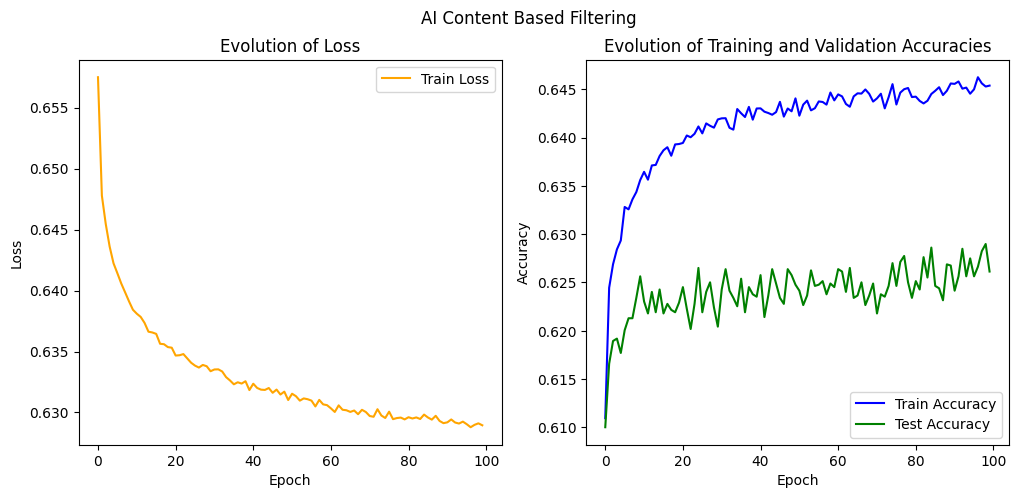

298/298 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
We recommend these 10 movies for User 1
      movieId                                             title  \
3389     4612      Jesus of Montreal (Jésus de Montréal) (1989)   
3451     4708                                 Marat/Sade (1966)   
1241     1650                          Washington Square (1997)   
1434     1957                           Chariots of Fire (1981)   
1268     1683                     Wings of the Dove, The (1997)   
3644     5008                Witness for the Prosecution (1957)   
1649     2202                                   Lifeboat (1944)   
7956    96084  Hands Over the City (Le mani sulla città) (1963)   
1759     2357        Central Station (Central do Brasil) (1998)   
2364     3134        Grand Illusion (La grande illusion) (1937)   

                      genres  
3389                   Drama  
3451           Drama Musical  
1241                   Drama  
1434                   Drama  
1268           Drama Roman

In [17]:
# Running AI Content Based Filtering.
user = 1 # Change the user

# Calling the class and function to run the model.
CBF = CBFModel()
CBF.forward()

# Gets the top 10 recommendations.
CBF_Recommendations = CBFRecommendations(user, model=CBF.classifier.model, movies_df=CBF.preprocessing.movies_df, ratings_df=CBF.preprocessing.ratings_df, tfidf_matrix=CBF.features.tfidf_matrix, lookup=CBF.features.lookup)
CBF_Recommendations.recommendations()

class EvaluateCBF:
    def __init__(self, model, X_test, y_test):
        self.model = model
        self.X_test = X_test
        self.y_test = y_test

    def evaluate(self):
        y_prediction = self.model.predict(self.X_test)
        # Threshold for the predicted rating to be liked or disliked.
        y_prediction = (y_prediction > 0.5).astype(int)

        # Evaluation scores
        print("Confusion Matrix:", confusion_matrix(self.y_test, y_prediction))
        print("Classification Report:", classification_report(self.y_test, y_prediction))
        print("Precision Score:", precision_score(self.y_test, y_prediction))
        print("Recall Score:",recall_score(self.y_test, y_prediction))
        print("F1 Score:", f1_score(self.y_test, y_prediction))
        print("RMSE Score:", root_mean_squared_error(self.y_test, y_prediction))
        print("Accuracy Score:", accuracy_score(self.y_test, y_prediction))

# Running the evaluation class.
Evaluation = EvaluateCBF(
    model = CBF.classifier.model,
    X_test = CBF.datasplit.X_test,
    y_test = CBF.datasplit.y_test
)
Evaluation.evaluate()

Epoch 1/100
568/568 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.1317 - loss: 0.6248 - val_accuracy: 0.1347 - val_loss: 0.6021
Epoch 2/100
568/568 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1367 - loss: 0.5906 - val_accuracy: 0.1362 - val_loss: 0.5987
Epoch 3/100
568/568 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1380 - loss: 0.5690 - val_accuracy: 0.1367 - val_loss: 0.6001
Epoch 4/100
568/568 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.1407 - loss: 0.5399 - val_accuracy: 0.1366 - val_loss: 0.6048
Epoch 5/100
568/568 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1429 - loss: 0.5252 - val_accuracy: 0.1352 - val_loss: 0.6087
Epoch 6/100
568/568 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.1448 - loss: 0.5170 - val_accuracy: 0.1347 - val_loss: 0.6136
Epoch 7/100
568/568 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.1436 - loss: 0.5135 - val_accuracy: 0.1347 - val_loss: 0.6179
Epoch 8/100
568/568 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1437 - loss: 0.5106 - val_accu

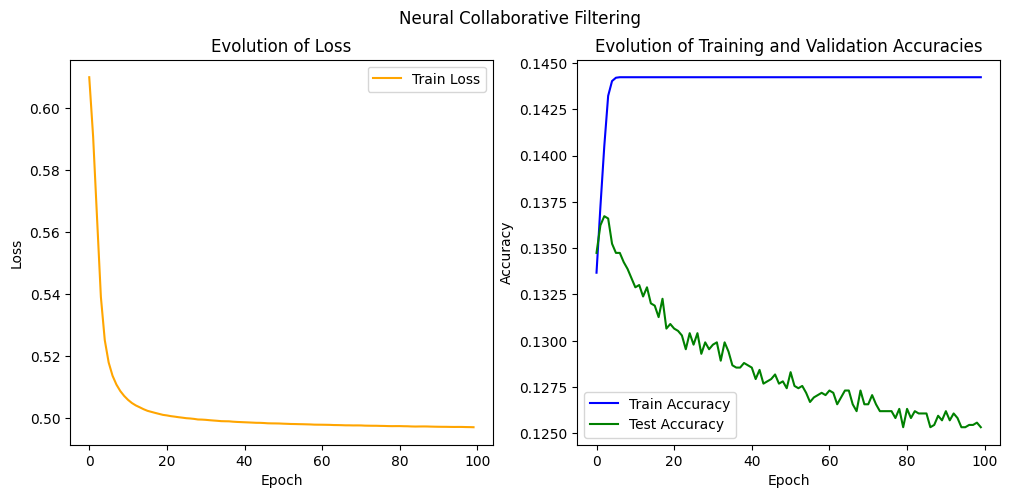

297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
We recommend these 10 movies for User 1
      movieId                                              title  \
277       318                   Shawshank Redemption, The (1994)   
602       750  Dr. Strangelove or: How I Learned to Stop Worr...   
868      1148        Wallace & Gromit: The Wrong Trousers (1993)   
896      1193             One Flew Over the Cuckoo's Nest (1975)   
951      1252                                   Chinatown (1974)   
1067     1387                                        Jaws (1975)   
1243     1653                                     Gattaca (1997)   
2453     3266  Man Bites Dog (C'est arrivé près de chez vous)...   
4135     5949                            Intact (Intacto) (2001)   
6772    60069                                      WALL·E (2008)   

                                           genres  
277                                   Crime Drama  
602                                    Comedy War  
868           

In [18]:
# Running Neural Collaborative Filtering
NCF = NCFModel()
NCF.forward()

# Gets the top 10 recommendations.
NCF_Recommendations = NCFRecommendations(user=user, model=NCF.classifier.model, movies_df=NCF.preprocessing.movies_df, ratings_df=NCF.preprocessing.ratings_df, user_index=NCF.encoder.userid_index, movie_index=NCF.encoder.movieid_index, movie_count=NCF.encoder.movie_count)
NCF_Recommendations.recommendations()

class EvaluateNCF:
    def __init__(self, model, X_test, y_test):
        self.model = model
        self.X_test = X_test
        self.y_test = y_test

    def evaluate(self):
        # Threshold for the test rating to be liked or disliked.
        self.y_test = (self.y_test > 0.5).astype(int)
        y_prediction = self.model.predict([self.X_test[:, 0], self.X_test[:, 1]])
        # Threshold for the predicted rating to be liked or disliked.
        y_prediction = (y_prediction > 0.5).astype(int)

        # Evaluation scores
        print("Confusion Matrix:", confusion_matrix(self.y_test, y_prediction))
        print("Classification Report:", classification_report(self.y_test, y_prediction))
        print("Precision Score:", precision_score(self.y_test, y_prediction))
        print("Recall Score:",recall_score(self.y_test, y_prediction))
        print("F1 Score:", f1_score(self.y_test, y_prediction))
        print("RMSE Score:", root_mean_squared_error(self.y_test, y_prediction))
        print("Accuracy Score:", accuracy_score(self.y_test, y_prediction))

# Running the evaluation class.
Evaluation = EvaluateNCF(
    model = NCF.classifier.model,
    X_test = NCF.datasplit.X_test,
    y_test = NCF.datasplit.y_test
)
Evaluation.evaluate()

In [19]:
# Running Neural Collaborative Filtering
Hybrid = HybridModel(ncf=NCF.classifier.model, cbf=CBF.classifier.model, movies_df=NCF.preprocessing.movies_df, ratings_df=NCF.preprocessing.ratings_df, user_index=NCF.encoder.userid_index, movie_index=NCF.encoder.movieid_index, movie_features=CBF.features.X, tfidf_matrix=CBF.features.tfidf_matrix, lookup=CBF.features.lookup
)

# Recommend movies to a specific user
Hybrid.forward(user=user, weight=0.5)

class EvaluateHybrid:
    def __init__(self, model, X_test, y_test, weight):
        self.model = model
        self.X_test = X_test
        self.y_test = y_test
        self.weight = weight

    def evaluate(self):
        y_prediction = self.model.predictions(self.X_test, self.weight)
        # Threshold for the predicted rating to be liked or disliked.
        y_prediction = (y_prediction > 0.5).astype(int)

        # Evaluation scores
        print("Confusion Matrix:", confusion_matrix(self.y_test, y_prediction))
        print("Classification Report:", classification_report(self.y_test, y_prediction))
        print("Precision Score:", precision_score(self.y_test, y_prediction))
        print("Recall Score:",recall_score(self.y_test, y_prediction))
        print("F1 Score:", f1_score(self.y_test, y_prediction))
        print("RMSE Score:", root_mean_squared_error(self.y_test, y_prediction))
        print("Accuracy Score:", accuracy_score(self.y_test, y_prediction))

# Running the evaluation class.
X_test, y_test = NCF.datasplit.X_test, NCF.datasplit.y_test
y_test = (y_test > 0.5).astype(int)
weight = 0.5
Evaluation = EvaluateHybrid(Hybrid, X_test, y_test, weight)
Evaluation.evaluate()

297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
We recommend these 10 movies for User 1
      movieId                                         title  predicted value
1119     1940                  Gentleman's Agreement (1947)         0.983036
3417     5379                          Believer, The (2001)         0.966399
2106     3341                         Born Yesterday (1950)         0.963332
2974     4612  Jesus of Montreal (Jésus de Montréal) (1989)         0.951959
631      1178                         Paths of Glory (1957)         0.947873
3036     4708                             Marat/Sade (1966)         0.941613
1977     3134    Grand Illusion (La grande illusion) (1937)         0.938387
2194     3469                       Inherit the Wind (1960)         0.937771
2330     3675                        White Christmas (1954)         0.934191
976      1683                 Wings of the Dove, The (1997)         0.933574
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s